In [1]:
import itertools
import numpy as np
import os
from tqdm import tqdm
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd


from genpen import genpen as gp, utils as utils
from scipy import stats as ss
import geopandas
import functools

%load_ext autoreload
%autoreload 2

from genpen.utils import Paper
import bezier
from dataclasses import asdict, dataclass, field

In [2]:
# make page
paper_size = '11x14 inches'
border:float=35
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [3]:
@dataclass
class CircleGrowerPruner(object):
    start_poly: Polygon
    rad_gen: None
    n_growth_candidates:int = 10
    
    def __post_init__(self):
        self.polys = [self.start_poly]
        
    @property
    def mp(self):
        return MultiPolygon(self.polys)
    
    @property
    def current_rad(self):
        return self.rad_gen()
    
    
    
    def get_touching_circle(
        self,
        max_attempts=1000,
    ):
        n_attempts = 0
        rad = self.rad_gen()
        while n_attempts < max_attempts:
            
            search_ring = self.mp.buffer(rad).boundary
            search_locs = np.arange(0, search_ring.length, 2*rad) 
            scrambled_search_locs = np.random.permutation(search_locs)
            for sl in scrambled_search_locs:
                pt = search_ring.interpolate(sl)
                c = pt.buffer(rad)
                if (not c.intersects(self.mp)):
                    return c
                n_attempts += 1
        
    def make_growth_candidates(self):
        self.growth_candidates = []
        for i in range(self.n_growth_candidates):
            cand = cgp.get_touching_circle()
            if cand is not None:
                self.growth_candidates.append(cand)
    
    def get_distance_from_center(self, geom):
        return geom.distance(self.mp.centroid)
    
    def get_distance_from_target(self, geom):
        return geom.distance(self.target)
    
    @property
    def candidate_distances(self):
        return [self.get_distance_from_target(gc) for gc in self.growth_candidates]
#         return [self.get_distance_from_center(gc) for gc in self.growth_candidates]
    
    def grow(self):
        self.make_growth_candidates()
        order = np.argsort(self.candidate_distances)
        best = self.growth_candidates[order[0]]
        self.polys.append(best)
        
    def prune_other(self, other_geom):
        distances = [p.distance(other_geom) for p in self.polys]
        order = np.argsort(distances)
        worst = order[0]
        self.polys.pop(worst)
        
    def prune(self,):
        distances = [p.hausdorff_distance(self.mp) for p in self.polys]
        order = np.argsort(distances)
        choice = order[0]
        self.polys.pop(choice)

In [27]:
start_poly = Point(140,50).buffer(3)
rad_gen = ss.uniform(loc=1, scale=5).rvs
cgp = CircleGrowerPruner(start_poly=start_poly, rad_gen=rad_gen, n_growth_candidates=5)
cgp.target = Point(140, 280)


In [28]:
for i in range(350):
    cgp.grow()

In [32]:
for i in range(50):
    cgp.grow()

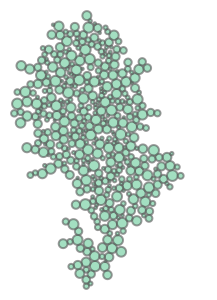

In [33]:
cgp.mp

In [10]:
bps = []
for p in cgp.mp:
    d = p.centroid.y
    buffer_dist = np.interp(d, [35, 320], [0, -2.5])
    bp = p.buffer(buffer_dist)
    bps.append(bp)

In [34]:
bps = []
for p in cgp.mp:
    d = p.centroid.y
    clip_dist = np.interp(d, [35, 320], [0, gp.get_rad(p)*2])
    bp = p.difference(sa.translate(p, xoff=clip_dist))
    bps.append(bp)

In [35]:
polys = gp.merge_Polygons(bps)

In [36]:


fbps = []
for _p in polys:
    area = np.log10(_p.area)
    p = gp.Poly(_p)
    n_iters = int(np.interp(area, [-3, 4.3], [1, 230]))
    stp = gp.ScaleTransPrms(n_iters = n_iters, d_buffer=-0.4, d_translate_factor=0., angles=np.random.uniform(0,np.pi*2))
    db_mults = gp.gaussian_random_walk(n=stp.d_buffers.shape[0], step_std=6.5, step_mu=0.)
    db_mults[db_mults<0.] = 0.05
    stp.d_buffers *= db_mults
#     stp.angles = np.linspace(0, np.radians(360*0.7), len(stp.d_buffers))
    p.fill_scale_trans(**stp.prms)
    fbps.append(p)

fills = gp.merge_LineStrings([p.fill for p in fbps])

In [38]:
sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.5mm')
sk.stroke(1)
sk.geometry(polys.boundary)

sk.display(color_mode='none')

<?xml version="1.0" encoding="utf-8" ?>
 
 
 
 
 image/svg+xml 
 
 2021-01-19T00:19:09.719874 
 
 
 
 
 
 <polygon points="485.3374,86.9897 484.7407,86.9604 483.6293,87.015 482.5286,87.1783 481.4493,87.4486 480.4016,87.8235 479.3957,88.2992 478.4413,88.8713 477.5475,89.5341 476.7231,90.2814 475.9758,91.1059 475.313,91.9996 474.7409,92.954 474.2652,93.9599 473.8903,95.0076 473.62,96.0869 473.4567,97.1876 473.4021,98.299 473.4567,99.4104 473.62,100.511 473.8903,101.5904 474.2652,102.6381 474.7409,103.644 475.313,104.5984 475.9758,105.4921 476.7231,106.3166 477.5475,107.0638 478.4413,107.7267 479.3957,108.2987 480.4016,108.7745 481.4493,109.1493 482.5286,109.4197 483.6293,109.583 484.7407,109.6376 485.3374,109.6083 484.8228,109.583 483.7222,109.4197 482.6428,109.1493 481.5951,108.7745 480.5892,108.2987 479.6348,107.7267 478.7411,107.0638 477.9166,106.3166 477.1694,105.4921 476.5065,104.5984 475.9345,103.644 475.4587,102.6381 475.0839,101.5904 474.8135,100.511 474.6502,99.4104 474.5956,98.299 474.6502,97.1876 474.8135,96.0869 475.0839,95.0076 475.4587,93.9599 475.9345,92.954 476.5065,91.9996 477.1694,91.1059 477.9166,90.2814 478.7411,89.5341 479.6348,88.8713 480.5892,88.2992 481.5951,87.8235 482.6428,87.4486 483.7222,87.1783 484.8228,87.015"/>
 <polygon points="485.5892,109.68 484.3309,109.6182 482.7516,109.6957 481.1875,109.9277 479.6538,110.3119 478.165,110.8446 476.7357,111.5207 475.3795,112.3335 474.1095,113.2754 472.9379,114.3373 471.876,115.5088 470.9341,116.7789 470.1213,118.1351 469.4452,119.5644 468.9125,121.0532 468.5284,122.5869 468.2963,124.151 468.2188,125.7303 468.2963,127.3095 468.5284,128.8736 468.9125,130.4073 469.4452,131.8961 470.1213,133.3254 470.9341,134.6817 471.876,135.9517 472.9379,137.1232 474.1095,138.1851 475.3795,139.127 476.7357,139.9399 478.165,140.6159 479.6538,141.1486 481.1875,141.5328 482.7516,141.7648 484.3309,141.8423 485.5892,141.7805 485.2682,141.7648 483.7042,141.5328 482.1704,141.1486 480.6817,140.6159 479.2523,139.9399 477.8961,139.127 476.6261,138.1851 475.4545,137.1232 474.3927,135.9517 473.4508,134.6817 472.6379,133.3254 471.9619,131.8961 471.4292,130.4073 471.045,128.8736 470.813,127.3095 470.7354,125.7303 470.813,124.151 471.045,122.5869 471.4292,121.0532 471.9619,119.5644 472.6379,118.1351 473.4508,116.7789 474.3927,115.5088 475.4545,114.3373 476.6261,113.2754 477.8961,112.3335 479.2523,111.5207 480.6817,110.8446 482.1704,110.3119 483.7042,109.9277 485.2682,109.6957"/>
 <polygon points="502.9272,101.5389 502.4145,101.5137 501.6188,101.5528 500.8308,101.6697 500.0581,101.8632 499.308,102.1316 498.5879,102.4722 497.9046,102.8818 497.2647,103.3563 496.6744,103.8913 496.1394,104.4816 495.6649,105.1215 495.2553,105.8048 494.9147,106.5249 494.6463,107.275 494.4528,108.0477 494.3359,108.8358 494.2968,109.6314 494.3359,110.4271 494.4528,111.2151 494.6463,111.9879 494.9147,112.738 495.2553,113.4581 495.6649,114.1414 496.1394,114.7813 496.6744,115.3715 497.2647,115.9065 497.9046,116.3811 498.5879,116.7906 499.308,117.1312 500.0581,117.3996 500.8308,117.5932 501.6188,117.7101 502.4145,117.7492 502.9272,117.724 502.6442,117.7101 501.8561,117.5932 501.0834,117.3996 500.3333,117.1312 499.6132,116.7906 498.9299,116.3811 498.29,115.9065 497.6997,115.3715 497.1647,114.7813 496.6902,114.1414 496.2806,113.4581 495.94,112.738 495.6716,111.9879 495.4781,111.2151 495.3612,110.4271 495.3221,109.6314 495.3612,108.8358 495.4781,108.0477 495.6716,107.275 495.94,106.5249 496.2806,105.8048 496.6902,105.1215 497.1647,104.4816 497.6997,103.8913 498.29,103.3563 498.9299,102.8818 499.6132,102.4722 500.3333,102.1316 501.0834,101.8632 501.8561,101.6697 502.6442,101.5528"/>
 <polygon points="506.8165,133.9867 506.7841,133.9819 505.2621,133.9071 503.7401,133.9819 502.2327,134.2055 500.7545,134.5757 499.3198,135.0891 497.9422,135.7406 496.6352,136.524 495.4112,137.4318 494.2821,138.4551 493.2588,139.5842 492.351,140.8082 491.5676,142.1152 490.9161,143.4928 490.4027,144.9275 490.0325,146.4057 489.8089,147.9131 489.7341,14

In [39]:

sk.vpype('linemerge --tolerance 0.1 linemerge --tolerance 0.1 linesimplify --tolerance 0.1 linesort')
sk.save('/mnt/c/code/side/plotter_images/oned_outputs/227_wax_wane.svg')